### Part II: Variational AutoEncoder (MNIST data)

In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

# We need to install the package 'torchvision' >> pip install torchvision
from torchvision import datasets, transforms

In [33]:
# The code can run on gpu (or) cpu, we can use the gpu if available. 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
BATCH_SIZE = 128         # number of data points in each batch
N_EPOCHS = 50           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 100        # hidden dimension
LATENT_DIM = 2         # latent vector dimension
lr = 1e-3               # learning rate

In [38]:
# To transform images into Tensors
transforms2 = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms2)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms2
)

In [39]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [53]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, z_dim):
        
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        
        super().__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        
        # x is of shape [batch_size, input_dim]
        hidden = F.relu(self.linear(x))
        
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        
        # z_var is of shape [batch_size, latent_dim]
        return z_mu, z_var

    
class Decoder(nn.Module):

    def __init__(self, z_dim, hidden_dim, output_dim):
        
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        # x is of shape [batch_size, latent_dim]
        hidden = F.relu(self.linear(x))
        
        # hidden is of shape [batch_size, hidden_dim]
        predicted = torch.sigmoid(self.out(hidden))
        
        # predicted is of shape [batch_size, output_dim]
        return predicted

    
class VAE(nn.Module):
    
    def __init__(self, enc, dec):
        
        super().__init__()
        
        self.enc = enc
        self.dec = dec

    def forward(self, x):
        
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.sqrt( torch.exp( z_var ) )
        eps = torch.normal(0, 1., z_mu.shape)
        x_sample = z_mu + eps * std

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

In [62]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [63]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(reconstruction_x, x, z_mean, z_var):
    
    # reconstruction loss
    BCE = F.binary_cross_entropy(reconstruction_x, x.view(-1, 784), reduction='sum')
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + z_var - z_mean.pow(2) - z_var.exp())

    return BCE + KLD


In [73]:
def train():
    # set the train mode
    model.train()
    torch.nn.utils.clip_grad_value_(model.parameters(), 5.)
    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # total loss
        loss = loss_function( x_sample, x, z_mu, z_var )

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [74]:
def test():
    
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # total loss
            loss = loss_function( x_sample, x, z_mu, z_var )
            test_loss += loss.item()

    return test_loss

In [76]:
best_test_loss = float('inf')

for epoch in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    
    print('>> epoch ', epoch)
    print('---> Train loss: >> ', train_loss)
    print('-----> Test loss: >> ', test_loss)
    print('')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

>> epoch  0
---> Train loss: >>  157.74658325195313
-----> Test loss: >>  157.2548311279297

>> epoch  1
---> Train loss: >>  157.29146421712238
-----> Test loss: >>  157.0645449951172

>> epoch  2
---> Train loss: >>  156.8042684407552
-----> Test loss: >>  156.65581154785156

>> epoch  3
---> Train loss: >>  156.45137751464844
-----> Test loss: >>  156.27007868652345

>> epoch  4
---> Train loss: >>  156.0243783203125
-----> Test loss: >>  156.13427192382812

>> epoch  5
---> Train loss: >>  155.71597561848958
-----> Test loss: >>  155.78206591796874

>> epoch  6
---> Train loss: >>  155.366953125
-----> Test loss: >>  155.63424411621094

>> epoch  7
---> Train loss: >>  155.11741905110676
-----> Test loss: >>  155.26793122558593

>> epoch  8
---> Train loss: >>  154.86954886067707
-----> Test loss: >>  155.06950092773437

>> epoch  9
---> Train loss: >>  154.55076381022135
-----> Test loss: >>  155.02514033203124

>> epoch  10
---> Train loss: >>  154.3560065266927
-----> Test loss:

torch.Size([1, 2])
torch.Size([28, 28])


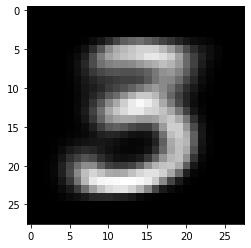

In [77]:
# Choose an image to generate and plot
z = torch.randn(1, LATENT_DIM).to(device)
reconstructed_img = model.dec(z)
img = reconstructed_img.view(28, 28).data

print(z.shape)
print(img.shape)
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

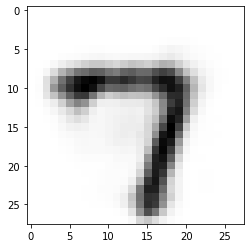

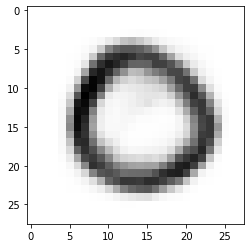

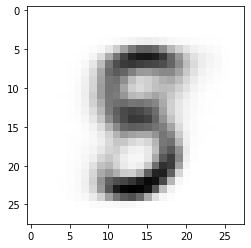

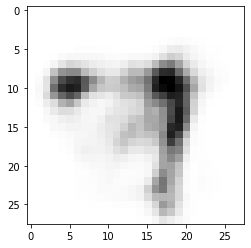

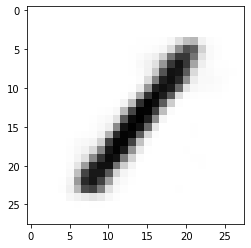

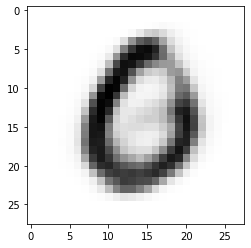

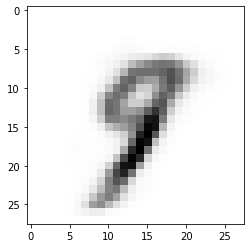

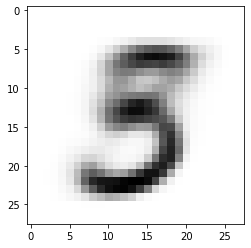

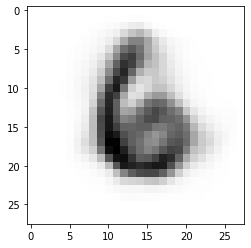

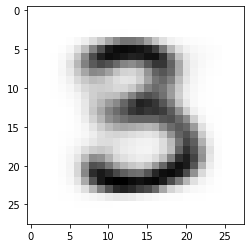

In [78]:
e = torch.normal(0, 1., (10, 2))
images = model.dec(e).sigmoid()

for i in range(10):
    picture = images[i].clone().detach().numpy()
    plt.imshow(picture.reshape(28,28), cmap='Greys')
    plt.show()